In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from IPython.display import clear_output
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
torch.manual_seed(1)


/home/student/anaconda3/envs/practical_rl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_pickle('train_data.pkl')
with open('letter_id_dict.pkl', 'rb') as f:
    letter_to_id = pickle.load(f)
vocab_size = len(letter_to_id)

In [3]:
all_categories = np.unique(data.strength)
n_categories = len(all_categories)

In [67]:
def to_matrix(lines, max_len=None, pad=letter_to_id['<pad>'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [letter_to_id.get(c, '<unknown>') for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # [batch, time] -> [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [68]:
to_matrix(data.password.sample(3).values).shape

(3, 12)

In [4]:
EMBEDDING_DIM = 8
HIDDEN_DIM =18

class Net(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim

        self.char_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.hidden2strength = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.char_embeddings(sentence)
        _, (hidden, cell_state) = self.lstm(embeds)
        hidden = torch.squeeze(hidden, dim=0)
        strength_space = self.hidden2strength(hidden)
        strength_scores = F.log_softmax(strength_space, dim=1)
        return strength_scores

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
model = Net(EMBEDDING_DIM, HIDDEN_DIM, vocab_size, n_categories)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

batch_size=256
history = []

In [12]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-1.5256, -0.7502, -0.6540,  ..., -0.6092, -0.9798, -1.6091],
        [-0.7121,  0.3037, -0.7773,  ...,  1.6871,  0.2284,  0.4676],
        [-0.6970, -1.1608,  0.6995,  ...,  0.2444, -0.6629,  0.8073],
        ...,
        [-1.0513, -2.5594, -0.3417,  ..., -2.3133,  2.2064,  0.6002],
        [-0.1766,  0.7251, -3.1347,  ..., -0.5670, -0.8304, -0.1374],
        [-0.6559, -0.8903,  1.7062,  ...,  0.1406, -1.8038, -1.3119]],
       requires_grad=True)
Parameter containing:
tensor([[-0.1172, -0.0928,  0.1486,  0.0671,  0.0540,  0.1049,  0.1096, -0.1703],
        [ 0.0188,  0.0225, -0.2277,  0.0500, -0.0031,  0.1828, -0.2250,  0.2217],
        [-0.1153,  0.1389,  0.1741, -0.0292, -0.1206, -0.0391, -0.1470,  0.0291],
        [ 0.0991,  0.0487, -0.1357,  0.1288,  0.2163, -0.0717,  0.1224, -0.0155],
        [ 0.0950, -0.1681, -0.2013, -0.0067, -0.1986,  0.0849,  0.2206, -0.0462],
        [ 0.0023,  0.0358, -0.1139, -0.0121,  0.0607,  0.1906, -0.1955, -0.0047],
   

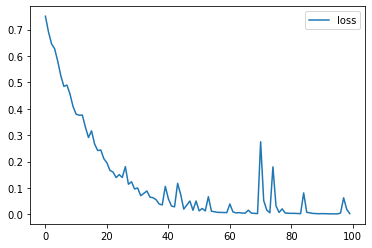

In [72]:
for epoch in range(100): 
    summary = 0
    for i in range(10**2):
        model.zero_grad()

        sample = data.sample(batch_size)
        inputs = torch.Tensor(to_matrix(sample.password.values)).long()
        targets = torch.Tensor(sample.strength.values).long()

        strength_scores = model(inputs)

        loss = loss_function(strength_scores, targets)
        loss.backward()
        optimizer.step()
        summary+=loss.data.numpy()
    history.append(summary/10**2)  
    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

In [73]:
test_data = pd.read_pickle('test_data.pkl')
with torch.no_grad():
    inputs = torch.Tensor(to_matrix(test_data.password.values)).long()
    strength_scores = model(inputs)

In [74]:
strength_scores = strength_scores.data.numpy()

In [75]:
predictions = np.argmax(strength_scores, axis=1)
y_test = test_data.strength.values

In [76]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, predictions)
f1_score = metrics.f1_score(y_test, predictions,average='macro')
precision = metrics.precision_score(y_test, predictions,average='macro')
recall = metrics.recall_score(y_test, predictions,average='macro')
accuracy, f1_score, precision, recall

(0.9994622250438809, 0.9991705326659912, 0.9994358690631957, 0.998906848416424)